# Sequence of Persistence Descriptors from a set of trajectories

## 1. Importing modules and setting parameters

In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import scipy.spatial.distance as dist
from navground import sim, core
# from tslearn.generators import random_walks
# from tslearn import metrics
# import seaborn as sns
import gudhi
from navground.sim.ui.video import display_video_from_run, record_video_from_run
from functools import partial
from IPython.display import Image

In [2]:
parser = argparse.ArgumentParser(description='Simulation Parameters')
parser.add_argument('--length', type=float, default=10.0, help='Length of the environment')
parser.add_argument('--width', type=float, default=10.0, help='Width of the environment')
parser.add_argument('--num_runs', type=int, default=1, help='Number of simulation runs')
parser.add_argument('--num_steps', type=int, default=100, help='Number of steps in the simulation')
parser.add_argument('--time_step', type=float, default=0.1, help='Time step for the simulation')
parser.add_argument('--num_agents', type=int, default=10, help='Number of agents in the simulation')
parser.add_argument('--max_speed', type=float, default=1.0, help='Maximum speed of agents')
parser.add_argument('--radius', type=float, default=0.25, help='Radius of agents')
parser.add_argument('--safety_margin', type=float, default=0.1, help='Safety margin for agents')
parser.add_argument('--behavior', type=str, default='HL', help='Behavior type')
parser.add_argument('--max_edge_length', type=float, default=100.0, help='Maximum edge length in the simplicial complex')
parser.add_argument('--time_delay', type=int, default=1, help='Time delay to analise simulation intervals')
parser.add_argument('--embedding_length', type=int, default=10, help='Length of the simulation intervals')
parser.add_argument('--factor', type=int, default=1, help='Velocity factor to display the animation')
parser.add_argument('--linewidth', type=float, default=1.0, help='Line width for plotting')
parser.add_argument('--gif_filename', type=str, default='animation.gif', help='Output filename for the .gif animation')
parser.add_argument('--png_filename', type=str, default='animation.mp4', help='Output filename for the .mp4 animation')

_StoreAction(option_strings=['--png_filename'], dest='png_filename', nargs=None, const=None, default='animation.mp4', type=<class 'str'>, choices=None, required=False, help='Output filename for the .mp4 animation', metavar=None)

In [3]:
args = parser.parse_args([
        '--length', '15.0',
        '--width', '2.5',
        '--num_runs', '1',
        '--num_steps', '2500',
        '--time_step', '0.25',
        '--num_agents', '10',
        '--max_speed', '0.5',
        '--radius', '0.25',
        '--safety_margin', '0.15',
        '--behavior', 'HL',
        '--max_edge_length', '22.0',
        '--time_delay', '5',
        '--embedding_length', '11',
        '--factor', '10',
        '--linewidth', '0.75',
        '--gif_filename', 'animation.gif',
        '--png_filename', 'animation.mp4'
    ])

In [4]:
weights = np.array([0,1/args.width,1/np.pi])

In [5]:
def normangle(angle):
    result = np.mod(angle, 2 * np.pi)
    result[result > np.pi] -= 2 * np.pi
    return result

List of behaviors:
* HL
* ORCA
* HRVO
* SocialForce

## 2. HL behavior

### Running the experiment

In [6]:
yaml = f"""
steps: {args.num_steps}
time_step: {args.time_step}
save_directory: ''
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
scenario:
  type: Corridor
  length: {args.length}
  width: {args.width}
  groups:
    -
      type: thymio
      number: {args.num_agents}
      radius: {args.radius}
      control_period: 0.1
      speed_tolerance: 0.02
      kinematics:
        type: 2WDiff
        wheel_axis: 0.094
        max_speed: {args.max_speed}
      behavior:
        type: {args.behavior}
        optimal_speed: {args.max_speed}
        horizon: 5.0
        safety_margin: {args.safety_margin}
      state_estimation:
        type: Bounded
        range: 5.0
"""
experiment = sim.load_experiment(yaml)
experiment.run()
runs = experiment.runs

In [7]:
runs

{0: <navground.sim._navground_sim.ExperimentalRun at 0x7f5370642110>}

In [8]:
record_video_from_run(path="simulation_HL.gif", run=runs[0], factor=10.0, fps=30)

MoviePy - Building file simulation_HL.gif with imageio.


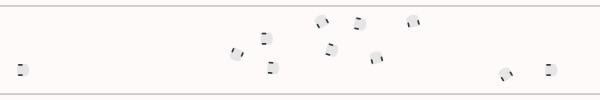

In [9]:
Image(filename='simulation_HL.gif')

### Computing the barcode sequence

Aquí es donde calculamos la trajectoria, realmente la trayectoria de un robot, son 3 series temporales, la de la posición x, la de la posición y y el ángulo. En este caso tenemos 2500 valores por serie temporal, que equivale al número de instancias de tiempo de la simulación, y la trayectoria es de cada robot, es decir en este caso, la trayectoria de cada robot está formada por 3 series temporales, una para la coordenada x, otra para la coordenada y , y otra para el angulo de visión.

In [10]:
trajectories = runs[0].poses.copy()
trajectories[:,:,2] = normangle(trajectories[:,:,2])

In [11]:
trajectories.shape

(2500, 10, 3)

In [12]:
np.arange(0,args.num_steps)

array([   0,    1,    2, ..., 2497, 2498, 2499])

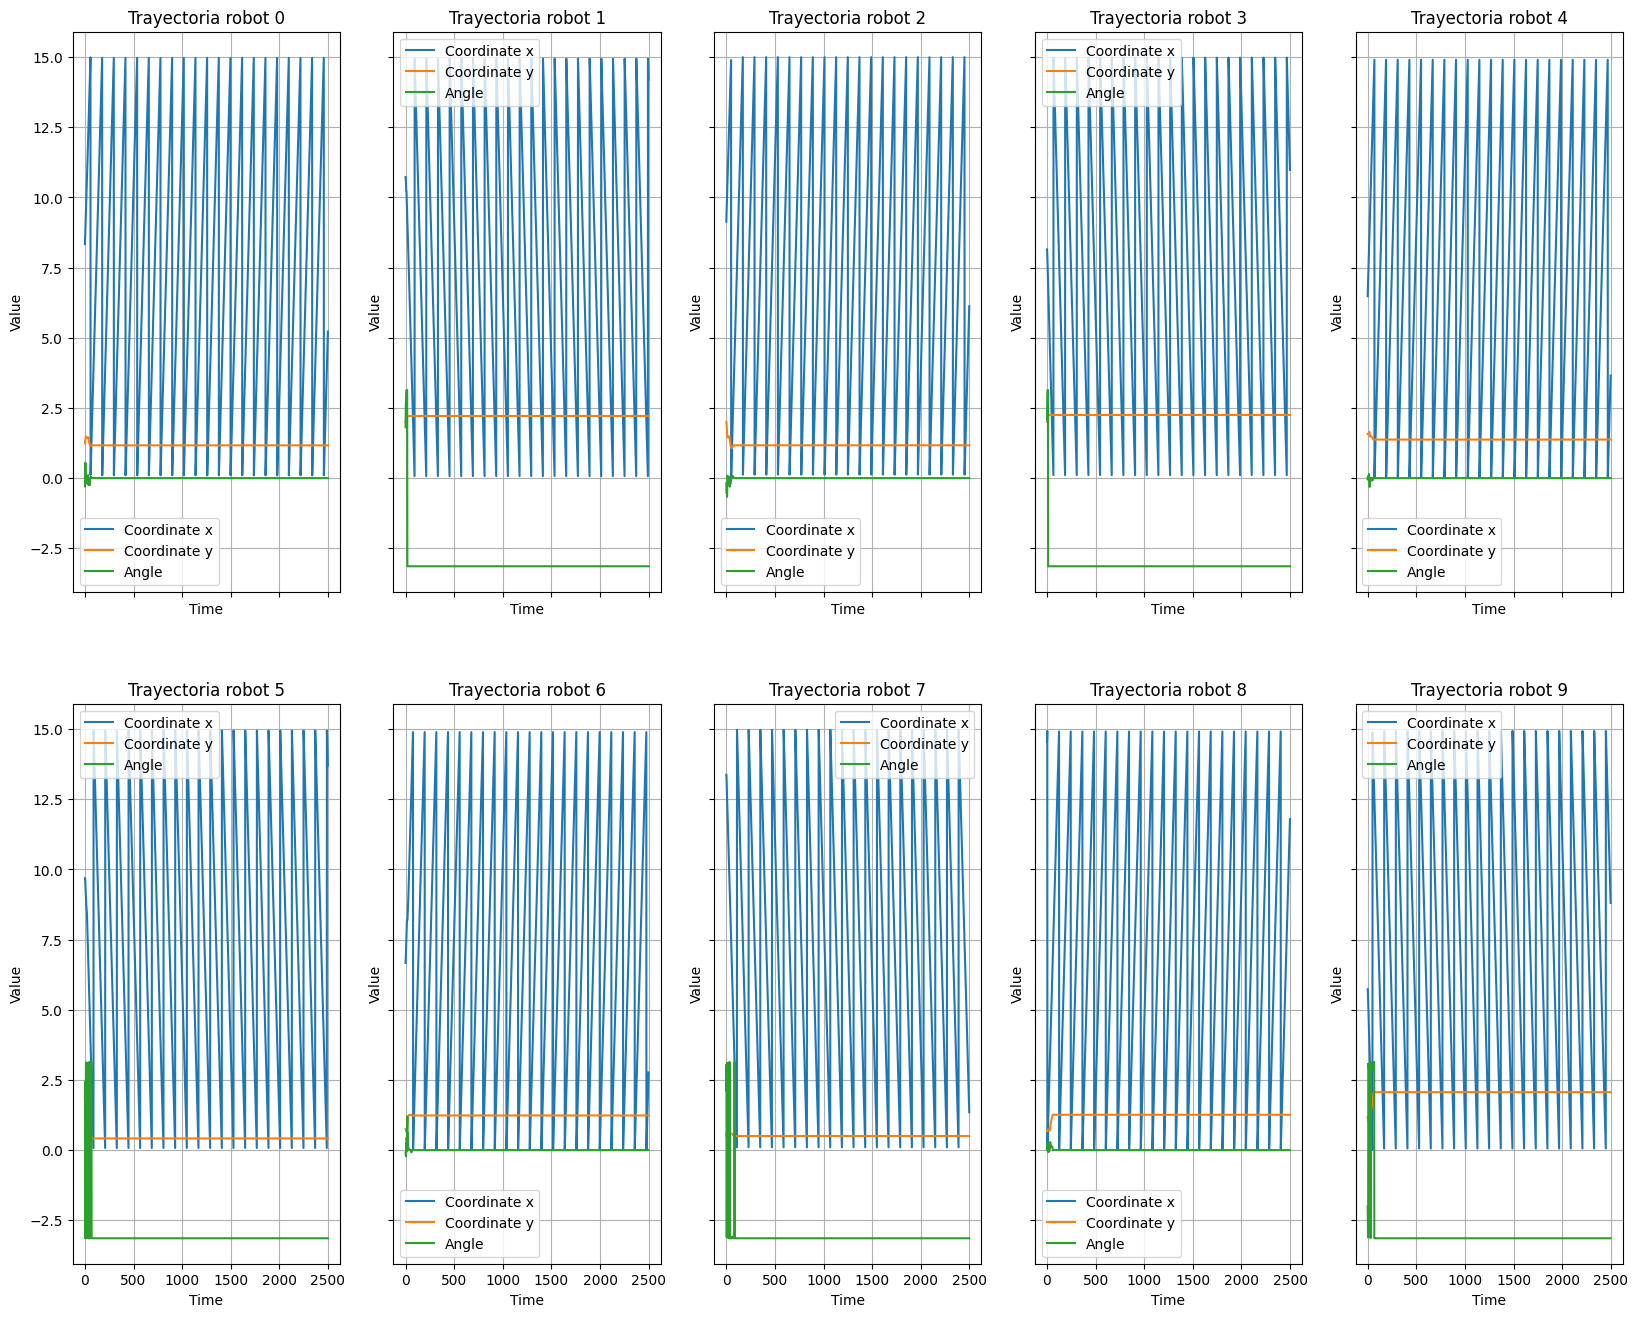

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 16), sharex=True, sharey=True)
axes = axes.flatten()
for robot in range(args.num_agents):
    plt.sca(axes[robot])
    for i in range(trajectories.shape[2]):
        if i == 0:
            label = "Coordinate x"
        elif i ==1:
            label = "Coordinate y"
        else:
            label = "Angle"
        plt.plot(np.arange(0,args.num_steps), trajectories[:,robot,i],linestyle='-', label=label)
        plt.title(f"Trayectoria robot {robot}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        
        # Mostrar el gráfico
plt.show()

In [10]:
def custom_distance(vector1, vector2, weights):
    result = 0
    # Pose distances
    if weights[0] != 0:
        px_diff = np.abs(vector1[0] - vector2[0])
        px_diff = np.minimum(px_diff, args.length - px_diff)
        result += px_diff * weights[0]

    if weights[1] != 0:
        py_diff = np.abs(vector1[1] - vector2[1])
        result += py_diff * weights[1]

    if weights[2] != 0:
        pr_diff = np.abs(vector1[2] - vector2[2])
        pr_diff = np.minimum(pr_diff, 2 * np.pi - pr_diff)
        result += pr_diff * weights[2]

    return result

In [11]:
custom_distance_with_param = partial(custom_distance, weights=weights)

In [12]:
sim_steps = trajectories.shape[0]
pers_list = []
total_iterations = sim_steps - (args.embedding_length - 1) * args.time_delay
for i in range (sim_steps - (args.embedding_length-1)*args.time_delay):
    progress = (i + 1) / total_iterations * 100
    print(f"Progress: {progress:.2f}% complete", end='\r')
    selected_steps = []
    for j in range(args.embedding_length):
        selected_steps.append(i+args.time_delay*j)
    dismat = np.zeros((args.num_agents, args.num_agents))
    for a in range(args.num_agents):
        for b in range(a+1):
            _, tsim = metrics.dtw_path_from_metric(trajectories[selected_steps,a,:], trajectories[selected_steps,b,:], metric=custom_distance_with_param)
            dismat[a,b] = tsim
    rips_complex = gudhi.RipsComplex(distance_matrix=dismat, max_edge_length=args.max_edge_length,sparse=None)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=0)
    simplex_tree.compute_persistence()
    pers = simplex_tree.persistence_intervals_in_dimension(0)
    pers[np.isinf(pers[:, 1]), 1] = args.max_edge_length
    pers_list.append(pers)   

### Evolution of persistent entropy

In [15]:
from gudhi import representations
pe = representations.Entropy()

In [17]:
pers_list

[array([[ 0.        ,  0.70218506],
        [ 0.        ,  0.80829705],
        [ 0.        ,  0.93644663],
        [ 0.        ,  2.11931523],
        [ 0.        ,  2.20081571],
        [ 0.        ,  2.40713549],
        [ 0.        ,  5.18441398],
        [ 0.        ,  5.29791408],
        [ 0.        , 10.63136161],
        [ 0.        , 22.        ]]),
 array([[ 0.        ,  0.66505004],
        [ 0.        ,  0.83446509],
        [ 0.        ,  1.03741339],
        [ 0.        ,  1.90271503],
        [ 0.        ,  2.01277157],
        [ 0.        ,  2.40334666],
        [ 0.        ,  5.135507  ],
        [ 0.        ,  5.15456385],
        [ 0.        , 10.73174758],
        [ 0.        , 22.        ]]),
 array([[ 0.        ,  0.70335054],
        [ 0.        ,  0.93091556],
        [ 0.        ,  0.98268604],
        [ 0.        ,  1.51357891],
        [ 0.        ,  1.84680915],
        [ 0.        ,  2.31790037],
        [ 0.        ,  4.95188522],
        [ 0.        ,  5

In [16]:
pe.fit_transform(pers_list)

array([[1.74862241],
       [1.73825462],
       [1.72108681],
       ...,
       [1.20875922],
       [1.20875922],
       [1.20875922]])

In [14]:
entropies_HL = (pe.fit_transform(pers_list).T)[0]
indices_HL = np.arange(len(entropies_HL))

### Animating the barcode sequence

In [15]:
def plot_length(length):
    return max(length,0.2)

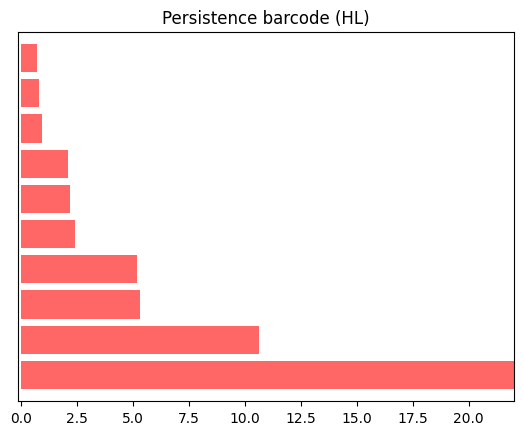

In [16]:
fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.set_xlim((-0.15,args.max_edge_length))
    ax.set_ylim((-0.75,args.num_agents - 0.25))
    ax.yaxis.set_ticks([])
    ax.set_title("Persistence barcode (HL)")
    birth = [b for (b, d) in pers_list[frame]]
    death = [d for (b, d) in pers_list[frame]]
    for i in range(len(pers_list[frame])):
        rect = patches.Rectangle((birth[i], i-0.4), plot_length(death[i]-birth[i]), 0.8, facecolor='r', alpha=0.6)
        ax.add_patch(rect)
    ax.invert_yaxis()

ani = animation.FuncAnimation(fig, update, frames=len(pers_list), blit=False, repeat=True)
ani.save('barcodes_HL.gif', writer='pillow', fps=30)

In [17]:
Image(filename='barcodes_HL.gif')

## 3. ORCA behavior

In [18]:
args.behavior = 'ORCA'

### Running the experiment

In [19]:
yaml = f"""
steps: {args.num_steps}
time_step: {args.time_step}
save_directory: ''
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
scenario:
  type: Corridor
  length: {args.length}
  width: {args.width}
  groups:
    -
      type: thymio
      number: {args.num_agents}
      radius: {args.radius}
      control_period: 0.1
      speed_tolerance: 0.02
      kinematics:
        type: 2WDiff
        wheel_axis: 0.094
        max_speed: {args.max_speed}
      behavior:
        type: {args.behavior}
        optimal_speed: {args.max_speed}
        horizon: 5.0
        safety_margin: {args.safety_margin}
      state_estimation:
        type: Bounded
        range: 5.0
"""
experiment = sim.load_experiment(yaml)
experiment.run()
runs = experiment.runs

In [20]:
record_video_from_run(path="simulation_ORCA.gif", run=runs[0], factor=10.0, fps=30)

MoviePy - Building file simulation_ORCA.gif with imageio.


In [21]:
Image(filename='simulation_ORCA.gif')

### Computing the barcode sequence

In [22]:
trajectories = runs[0].poses.copy()
trajectories[:,:,2] = normangle(trajectories[:,:,2])

In [23]:
sim_steps = trajectories.shape[0]
pers_list = []
total_iterations = sim_steps - (args.embedding_length - 1) * args.time_delay
for i in range (sim_steps - (args.embedding_length-1)*args.time_delay):
    progress = (i + 1) / total_iterations * 100
    print(f"Progress: {progress:.2f}% complete", end='\r')
    selected_steps = []
    for j in range(args.embedding_length):
        selected_steps.append(i+args.time_delay*j)
    dismat = np.zeros((args.num_agents, args.num_agents))
    for a in range(args.num_agents):
        for b in range(a+1):
            _, tsim = metrics.dtw_path_from_metric(trajectories[selected_steps,a,:], trajectories[selected_steps,b,:], metric=custom_distance_with_param)
            dismat[a,b] = tsim
    rips_complex = gudhi.RipsComplex(distance_matrix=dismat, max_edge_length=args.max_edge_length,sparse=None)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=0)
    simplex_tree.compute_persistence()
    pers = simplex_tree.persistence_intervals_in_dimension(0)
    pers[np.isinf(pers[:, 1]), 1] = args.max_edge_length
    pers_list.append(pers)   

### Evolution of persistent entropy

In [24]:
entropies_ORCA = (pe.fit_transform(pers_list).T)[0]
indices_ORCA = np.arange(len(entropies_ORCA))

### Animating the barcode sequence

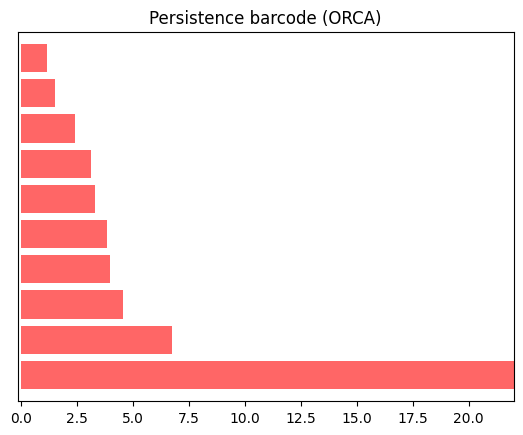

In [25]:
fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.set_xlim((-0.15,args.max_edge_length))
    ax.set_ylim((-0.75,args.num_agents - 0.25))
    ax.yaxis.set_ticks([])
    ax.set_title("Persistence barcode (ORCA)")
    birth = [b for (b, d) in pers_list[frame]]
    death = [d for (b, d) in pers_list[frame]]
    for i in range(len(pers_list[frame])):
        rect = patches.Rectangle((birth[i], i-0.4), plot_length(death[i]-birth[i]), 0.8, facecolor='r', alpha=0.6)
        ax.add_patch(rect)
    ax.invert_yaxis()

ani = animation.FuncAnimation(fig, update, frames=len(pers_list), blit=False, repeat=True)
ani.save('barcodes_ORCA.gif', writer='pillow', fps=30)

In [26]:
Image(filename='barcodes_ORCA.gif')

## 4. HRVO behavior

In [27]:
args.behavior = 'HRVO'

### Running the experiment

In [28]:
yaml = f"""
steps: {args.num_steps}
time_step: {args.time_step}
save_directory: ''
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
scenario:
  type: Corridor
  length: {args.length}
  width: {args.width}
  groups:
    -
      type: thymio
      number: {args.num_agents}
      radius: {args.radius}
      control_period: 0.1
      speed_tolerance: 0.02
      kinematics:
        type: 2WDiff
        wheel_axis: 0.094
        max_speed: {args.max_speed}
      behavior:
        type: {args.behavior}
        optimal_speed: {args.max_speed}
        horizon: 5.0
        safety_margin: {args.safety_margin}
      state_estimation:
        type: Bounded
        range: 5.0
"""
experiment = sim.load_experiment(yaml)
experiment.run()
runs = experiment.runs

In [29]:
record_video_from_run(path="simulation_HRVO.gif", run=runs[0], factor=10.0, fps=30)

MoviePy - Building file simulation_HRVO.gif with imageio.


In [30]:
Image(filename='simulation_HRVO.gif')

### Computing the barcode sequence

In [31]:
trajectories = runs[0].poses.copy()
trajectories[:,:,2] = normangle(trajectories[:,:,2])

In [32]:
sim_steps = trajectories.shape[0]
pers_list = []
total_iterations = sim_steps - (args.embedding_length - 1) * args.time_delay
for i in range (sim_steps - (args.embedding_length-1)*args.time_delay):
    progress = (i + 1) / total_iterations * 100
    print(f"Progress: {progress:.2f}% complete", end='\r')
    selected_steps = []
    for j in range(args.embedding_length):
        selected_steps.append(i+args.time_delay*j)
    dismat = np.zeros((args.num_agents, args.num_agents))
    for a in range(args.num_agents):
        for b in range(a+1):
            _, tsim = metrics.dtw_path_from_metric(trajectories[selected_steps,a,:], trajectories[selected_steps,b,:], metric=custom_distance_with_param)
            dismat[a,b] = tsim
    rips_complex = gudhi.RipsComplex(distance_matrix=dismat, max_edge_length=args.max_edge_length,sparse=None)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=0)
    simplex_tree.compute_persistence()
    pers = simplex_tree.persistence_intervals_in_dimension(0)
    pers[np.isinf(pers[:, 1]), 1] = args.max_edge_length
    pers_list.append(pers)   

### Evolution of persistent entropy

In [33]:
entropies_HRVO = (pe.fit_transform(pers_list).T)[0]
indices_HRVO = np.arange(len(entropies_HRVO))

### Animating the barcode sequence

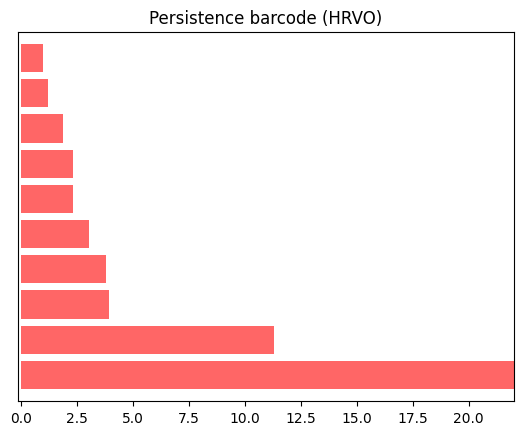

In [34]:
fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.set_xlim((-0.15,args.max_edge_length))
    ax.set_ylim((-0.75,args.num_agents - 0.25))
    ax.yaxis.set_ticks([])
    ax.set_title("Persistence barcode (HRVO)")
    birth = [b for (b, d) in pers_list[frame]]
    death = [d for (b, d) in pers_list[frame]]
    for i in range(len(pers_list[frame])):
        rect = patches.Rectangle((birth[i], i-0.4), plot_length(death[i]-birth[i]), 0.8, facecolor='r', alpha=0.6)
        ax.add_patch(rect)
    ax.invert_yaxis()

ani = animation.FuncAnimation(fig, update, frames=len(pers_list), blit=False, repeat=True)
ani.save('barcodes_HRVO.gif', writer='pillow', fps=30)

In [35]:
Image(filename='barcodes_HRVO.gif')

## 5. SocialForce behavior

args.behavior = 'SocialForce'

### Running the experiment

yaml = f"""
steps: {args.num_steps}
time_step: {args.time_step}
save_directory: ''
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
scenario:
  type: Corridor
  length: {args.length}
  width: {args.width}
  groups:
    -
      type: thymio
      number: {args.num_agents}
      radius: {args.radius}
      control_period: 0.1
      speed_tolerance: 0.02
      kinematics:
        type: 2WDiff
        wheel_axis: 0.094
        max_speed: {args.max_speed}
      behavior:
        type: {args.behavior}
        optimal_speed: {args.max_speed}
        horizon: 5.0
        safety_margin: {args.safety_margin}
      state_estimation:
        type: Bounded
        range: 5.0
"""
experiment = sim.load_experiment(yaml)
experiment.run()
run = experiment.runs[0]

record_video_from_run(path="simulation_SF.gif", run=run, factor=10.0, fps=30)

Image(filename='simulation_SF.gif')

### Computing the barcode sequence

trajectories = run.poses.copy()
trajectories[:,:,2] = normangle(trajectories[:,:,2])

In [ ]:
sim_steps = trajectories.shape[0]
pers_list = []
total_iterations = sim_steps - (args.embedding_length - 1) * args.time_delay
for i in range (sim_steps - (args.embedding_length-1)*args.time_delay):
    progress = (i + 1) / total_iterations * 100
    print(f"Progress: {progress:.2f}% complete", end='\r')
    selected_steps = []
    for j in range(args.embedding_length):
        selected_steps.append(i+args.time_delay*j)
    dismat = np.zeros((args.num_agents, args.num_agents))
    for a in range(args.num_agents):
        for b in range(a+1):
            _, tsim = metrics.dtw_path_from_metric(trajectories[selected_steps,a,:], trajectories[selected_steps,b,:], metric=custom_distance_with_param)
            dismat[a,b] = tsim
    rips_complex = gudhi.RipsComplex(distance_matrix=dismat, max_edge_length=args.max_edge_length,sparse=None)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=0)
    simplex_tree.compute_persistence()
    pers = simplex_tree.persistence_intervals_in_dimension(0)
    pers[np.isinf(pers[:, 1]), 1] = args.max_edge_length
    pers_list.append(pers)    

### Evolution of persistent entropy

entropies_SF = (pe.fit_transform(pers_list).T)[0]
indices_SF = np.arange(len(entropies_SF))

### Animating the barcode sequence

fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.set_xlim((-0.15,args.max_edge_length))
    ax.set_ylim((-0.75,args.num_agents - 0.25))
    ax.yaxis.set_ticks([])
    ax.set_title("Persistence barcode (SF)")
    birth = [b for (b, d) in pers_list[frame]]
    death = [d for (b, d) in pers_list[frame]]
    for i in range(len(pers_list[frame])):
        rect = patches.Rectangle((birth[i], i-0.4), plot_length(death[i]-birth[i]), 0.8, facecolor='r', alpha=0.6)
        ax.add_patch(rect)
    ax.invert_yaxis()

ani = animation.FuncAnimation(fig, update, frames=len(pers_list), blit=False, repeat=True)
ani.save('barcodes_SF.gif', writer='pillow', fps=30)

Image(filename='barcodes_SF.gif')

## 6. Behaviors comparison

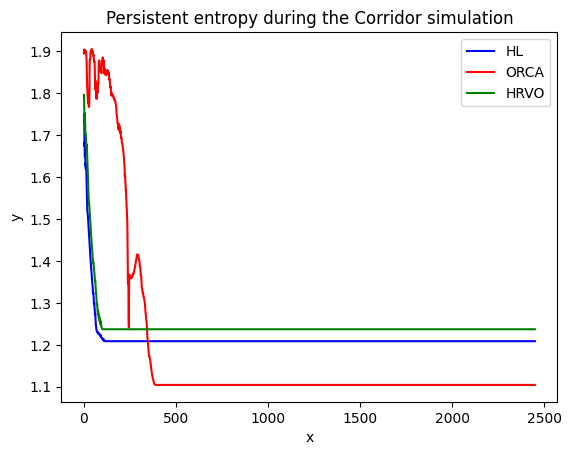

In [36]:
# Plotting each line with a different color and label
plt.plot(indices_HL, entropies_HL, color='blue', label='HL')
plt.plot(indices_ORCA, entropies_ORCA, color='red', label='ORCA')
plt.plot(indices_HRVO, entropies_HRVO, color='green', label='HRVO')
# plt.plot(indices_SF, entropies_SF, color='purple', label='SF')

# Adding a legend
plt.legend()

# Adding labels and a title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Persistent entropy during the Corridor simulation')

# Save the plot as a PNG file
plt.savefig('comparison.png', format='png', dpi=300)

# Show the plot
plt.show()